MNIST for Tensorflow-lite
----

This notebook is part of this [post](https://www.stupid-projects.com/machine-learning-on-embedded-part-3) which is part a series of post about using ML and NN in embedded MCUs. The first post of the series is [here](https://www.stupid-projects.com/machine-learning-on-embedded-part-1)

This notebook is just a port of [this](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb) notebook from Keras to TF.

This notebook is meant to be used to train the MNIST NN and then export the model to TF-Lite for microcontrollers and uploaded to a stm32f746. Later there's a cell in the notebook that you can hand-draw a number on a window and then evaluate the model on both the notebook and the stm32f746 by running the inference.



## 1. Create the model

As it's mentioned before, this is just a port from Keras to TF of [this](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb) notebook. For the model training we're going to use `convnets`.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version {}".format(tf.__version__))

TensorFlow version 1.14.0


In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

#### Convert train and test data
Normally when the dataset is loaded the shape is (x, 28, 28). For convnets you need to reshape the data to (x, 28, 28, y), where `x` is the number of images per set and `y` in this case is the number of colors. Normally, of RGB it should be 3, but since the images are grayscale then it's 1.

In [3]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [4]:
print("Data type:", type(train_images))
print("Dataset shape:", (train_images.shape))

Data type: <class 'numpy.ndarray'>
Dataset shape: (60000, 28, 28, 1)


In [5]:
print("Labels:", len(train_labels))
print("Possible values:", np.unique(train_labels))

Labels: 60000
Possible values: [0. 1.]


#### Print a digit from the dataset
Now we just print a digit from the dataset in order to see how it looks like.

In [6]:
def display_img(img):
    img = np.array(img, dtype='float')
    pixels = img.reshape((28, 28))
    plt.figure()
    plt.imshow(pixels, cmap='gray')
    plt.colorbar()
    plt.grid(False)
    plt.xlabel("Classification label: {}".format(train_labels[0]))
    plt.show()

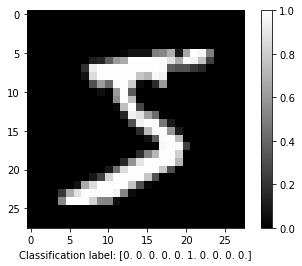

In [7]:
display_img(train_images[0])

## 2. Train the model

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 10s 161us/sample - loss: 0.1702 - acc: 0.9470
Epoch 2/5
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0476 - acc: 0.9850
Epoch 3/5
60000/60000 [==============================] - 9s 155us/sample - loss: 0.0329 - acc: 0.9901
Epoch 4/5
60000/60000 [==============================] - 9s 153us/sample - loss: 0.0251 - acc: 0.9923
Epoch 5/5
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0203 - acc: 0.9939


In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 67us/sample - loss: 0.0308 - acc: 0.9906
Test accuracy: 0.9906


In [12]:
model.summary()
loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {}".format(loss))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

## 3. Convert the model to tflite

Now we need to export the model and save it in a `h5` file. Then we use the `TFLiteConverter` to convert the model to the flatbuffer tflite format.

Normally, we should use quantization on the model as it's explained [here](https://www.tensorflow.org/lite/microcontrollers/build_convert#quantization), but for some reason in the current version I'm using (1.14) that doesn't work and when the model is loaded on the stm32f746, then I get this error:

```
Only float32, int16, int32, int64, uint8, bool, complex64 supported currently
```

This error comes from the `source/libs/tensorflow/lite/experimental/micro/simple_tensor_allocator.cc` file and the reason is that when the model is converted with `TFLiteConverter`, then the output is set to `kTfLiteInt8`, which means signed integer and that is not yet supported.

In [13]:
model.save('mnist-tflite.h5')

> Note: If you want to add post-quantization during conversion (which doesn't work yet), then you need to uncomment the line in the next code. Finally, the output of the next command is the size of the flatbuffer model in bytes.

In [26]:
tflite_mnist_model = 'mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model_file('mnist-tflite.h5')
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
flatbuffer_size = open(tflite_mnist_model, "wb").write(tflite_model)

print('The size of the converted flatbuffer is: %d bytes' % flatbuffer_size)

The size of the converted flatbuffer is: 375740 bytes


## 4. Create a header file from the tflite model
Now that you have your tflite flatbuffer you can convert it to a header file
in order to add it to your C++ code you need to run this command in bash in
the `jupyter _notebook` folder.

```sh
xxd -i jupyter_notebook/mnist.tflite > source/src/inc/model_data.h
```

#### Note:
In the `source/src/inc/model_data.h` you need to change this line:
```cpp
unsigned char jupyter_notebook_mnist_tflite[] = {
```
to this:
```cpp
const unsigned char jupyter_notebook_mnist_tflite[] = {
```
Otherwise it won't fit in the RAM and you'll get this error:
```sh
stm32f7-mnist-tflite.elf section `.bss' will not fit in region `RAM'
```

## 5. Load model and interpreter

To evaluate the hand-written digit in the notebook then you need to create an interpreter and then feed the image (or array) in the input. You can create that here and use it later in the document.

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_mnist_model)
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: conv2d_3_input
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: dense_3/Softmax
shape: [ 1 10]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'conv2d_3_input', 'index': 3, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}

DUMP OUTPUT
{'name': 'dense_3/Softmax', 'index': 15, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}


## 5. Evalutate the model

In order to make it more interesting, I've wrote a small python that you can draw a digit with your mouse and then ran the prediction function to evaluate the result. For this purpose I'm using tkinter and the PIL library. Therefore you need to install them in your environment.

For ubuntu (I'm using conda):
```sh
sudo apt install python3-tk
conda install Pillow
```

#### How to use:
Run the following two cells and this window will show up.

![Image](./MnistDigitDraw/digit_draw_1.png)

In the left window you can draw any digit with your mouse by clicking in the white area. Just be sure that you don't draw that too fast because then you get dotted lines. Then you can either press one of the following buttons:
* `Clear`: clears the input drawing area
* `Export`: Converts the draw digit to the MNIST input format and then exports the digit to a file called `digit.txt`. You can use this file in this notebook and evaluate the result.
* `Inference`: Converts the digit to the MNIST input format and sends the data to the MCU via the serial port. Then the MCU runs the prediction and returns an array with the output values and the time that spend for the calculation.

This is an example (I'm right-handed but I'm the mouse with my left hand, this is why it seems so ugly, lol).

![Image](./MnistDigitDraw/digit_draw_2.png)


Anyway, try yourself by running the next two cells.

> Warning: If you proceed with the export function and local evaluation, then you need first to terminate the tkinter window, because the notebook is not able to run 2 cells at the same time. Therefore, if the window thread is running then no other cell can be run.

> Note: Be carefull that if you do any changes in any python class or script that is already loaded from the jupyter notebook kernel, then you need to restart the kernel (File menu: Kernel-> Restart). Otherwise the previous loaded class will be used!

In [27]:
from matplotlib import pyplot as plt
from tkinter import *
from MnistDigitDraw.MnistDigitDraw import MnistDigitDraw
import numpy as np

You can run the followinf cell how many times you like in order to draw a new digit every time. When you do, then press the `Inference` button, then the `Export` and then close the window to proceed.

In [28]:
# Open the TK window to draw the digit and save it in a file
root = Tk()
root.title("MNIST digit draw")
d = MnistDigitDraw(root, 250, 250)
d.start()
root.mainloop()

# Load digit from the file that created above
digit = np.loadtxt('digit.txt')
# Reshape
loaded_digit = digit.reshape(28,28)
loaded_digit = np.expand_dims(loaded_digit, axis=0)
loaded_digit = np.expand_dims(loaded_digit, axis=3)
loaded_digit.shape

Not implemented yet...


(1, 28, 28, 1)

## 6. Load the digit that you drew

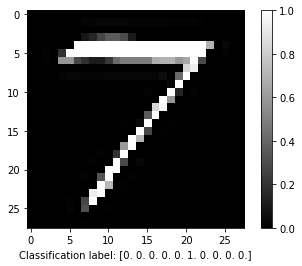

In [23]:
display_img(loaded_digit)

## 8. Evaluate hand-written digit on the notebook

In case you wnt to test your hand-written digit here then run the following cells. The next cells will load the `digit.txt` file which was exported in the previous step.

The imported digit share is (768,). If you just open the file in a text editor (or cat the file) you'll see that each pixel value is one line. Therefore, after loading the digit then you need to convert from `(768,)` to `(1, 28, 28, 1)`, which is the format that the model prediction function support. To do that you need first to reshape the array to `(28, 28)` and then add two additional dimension in the tensor, one dimension in the beginning and one in the end. Those don't need to have a value, the first dimension is used as an index and the last as the prediction result, but it this case we don't care for any of them.

In [24]:
loaded_digit = loaded_digit.astype('float32')
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], loaded_digit)

interpreter.invoke()

output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results:", output_data)
print("Predicted value:", np.argmax(output_data))

Prediction results: [[5.2731049e-11 3.5118972e-04 1.0486418e-02 1.9052246e-05 1.1133269e-06
  1.8441332e-08 1.0014380e-11 9.8913854e-01 2.9100825e-06 7.1789026e-07]]
Predicted value: 7


From the above result the one which has the larger value is the predicted digit.

## 9. Evaluate on the STM32F746

Now you can convert the digit and upload it to the stm32 for evaluation in the model that is running in the embedded board. See in section 10, how to connect the board to your PC.

In [51]:
# Import the custom flatbuffer communication module for the STM32
from FbComm.FbComm import FbComm

### 9.1 Check connection
To check the connection between your workstation and the stm32f743 you can run the following command, which will retrieve the version and the CPU frequency.

In [52]:
# Select the proper com port for your system
serial = FbComm(uart = '/dev/ttyUSB0')
serial.reqStats()

Comm initialized
Requesting stats...
Receiving stats...
Command: 0
Version: 100
Freq: 216000000


### 9.2 Test hand-draw digit

Now you can test the digit you've drawn on the STM32 by running the following cell. Then you can compare the result you got from step #8

> Note: This script might take a few seconds to return

In [55]:
serial = FbComm(uart = '/dev/ttyUSB0')
serial.reqInference(digit)

Comm initialized
Num of elements: 784
Sending image data
Receive results...
Command: 2
Execution time: 2991 msec
Out[9]: 0.000000
Out[8]: 0.000000
Out[7]: 0.999986
Out[6]: 0.000000
Out[5]: 0.000000
Out[4]: 0.000000
Out[3]: 0.000000
Out[2]: 0.000007
Out[1]: 0.000007
Out[0]: 0.000000


## 10. Export hand-draw digit for use in the source code

For testing and development you can export the digit you've drawn in a header file and then compile the code and upload it to the stm32f7. When you do that, then in order to save RAM you need to convert the array to `const`. The following script does that for you, though.

> Note: Only run the next cell if you want to override the default digit in the flash.

In [56]:
bytes = digit.tobytes
np.save("bytes.txt", bytes)
f= open("../source/src/inc/digit.h","w+")
f.write("const float digit[] = { \n")
for d in digit:
    f.write(str(d))
    f.write(',')
f.write('\n};')
f.close()

## 11. Build the code and compile

Now on your console run these commands to build and flash the project on the stm32f746

```sh
CLEANBUILD=true USE_HAL_DRIVER=ON SRC=src ./build.sh
./flash.sh
```

> Note: Before you build you need to set the toolchain in your `source/CMakeLists.txt` file. Open the file and uncomment this line:
```cmake
set(TOOLCHAIN_DIR "/opt/toolchains/gcc-arm-none-eabi-8-2018-q4-major")
```
Then insert the path of your toolchain. You can find the latest toolchain [here](https://developer.arm.com/tools-and-software/open-source-software/developer-tools/gnu-toolchain/gnu-rm/downloads)

You can repeat hand-drawing and upload or flash procedure as many times you like.

## 12. Testing the FbComm module

The FbComm.py is a Python module that I've made in order to create a proxy between this notebook and the STM32F7 board in order to use the serial port to send/receive data. Because during development, testing and debuging is not optimal (and actually very slow) to test the communication and the parsing of the flatbuffers by compiliing and uploading code to the board; I've also written a small C++ tool that used TCP sockets and `emulates` the board.

The `FbComm` class in the `FbComm.py` supports both a serial and a TCP connection. Therefore, you can use your PC to develop the C++ code for develop the serialization and de-serialization with flatbuffers. You can do that by using the `jupyter_notebook/FbComm/test_cpp_app/fb_comm_test.cpp` and `jupyter_notebook/FbComm/FbComm.py` with the TCP connection.

For example, this is how to use `FbComm` with TCP:

```py
com = FbComm(ip='127.0.0.1', port='32001')
com.reqStats()
com.reqInference(digit)
```

And this is for the UART/Serial port:
```py
com = FbComm(uart='/dev/ttyUSB0')
com.reqStats()
com.reqInference(digit)
```

If you run this outside from the notepad then you need first to save a digit from the notepad and then load the digit from the python code. Like this:

In [58]:
# This will save the digit to 'digit.npy' file.
np.save('digit', digit)

Now from your script you can load the digit and use FbComm like this:
```py
digit = np.load('digit.npy')
com = FbComm(ip='127.0.0.1', port='32001')
com.reqStats()
com.reqInference(digit)
```

## 13. Connecting the board to your PC

The STM32F7 firmware supports two UART ports (both @ 115200 bps). Those two have different usage:

#### 13.1 `USART6`
Debug port that accepts ASCII commands and also prints out debugging messages. The handler for this port is in `main.cpp` in the `dbg_uart_parser()` function and the supported commands for this port are:

```CMD=<command id>\n```
where `\n`, is a newline character and `<command id>` is a number with the following meaning:

* `1`: Prints the NN model view. Example with print-out:

Command:
```sh
CMD=1
```
Response:
```sh
Received: CMD=1

Model input:
dims->size: 4
dims->data[0]: 1
dims->data[1]: 28
dims->data[2]: 28
dims->data[3]: 1
input->type: 1

Model output:
dims->size: 2
dims->data[0]: 1
dims->data[1]: 10

Testing mode: 1
```
* `2`: Runs the inference by using the hard-coded digit in `source/src/inc/digit.h` and prints stats with how much time each layer takes. Read #10 on how to change this.

Command:
```sh
CMD=1
```
Response:
```sh
Received: CMD=2␍

Running inference...
DEPTHWISE_CONV_2D: 243 msec

MAX_POOL_2D: 23 msec

CONV_2D: 2347 msec

MAX_POOL_2D: 7 msec

CONV_2D: 348 msec

FULLY_CONNECTED: 6 msec

FULLY_CONNECTED: 0 msec

SOFTMAX: 0 msec

Done in 2990 msec...
Out[0]: 0.000000
Out[1]: 0.000000
Out[2]: 0.000000
Out[3]: 0.000000
Out[4]: 0.000000
Out[5]: 1.000000
Out[6]: 0.000000
Out[7]: 0.000000
Out[8]: 0.000000
Out[9]: 0.000000
Testing mode: 2
```

> Note: You can expand the supported commands in `main.cpp::dbg_uart_parser()`.

#### 13.2 `UART7`

This is the flatbuffer uart port which is used for the communication between this notepad and the STM32F7.

#### 13.3 Connections

The [STM32F746G-DISCO](https://www.st.com/en/evaluation-tools/32f746gdiscovery.html#overview) has an Arduino UNO-like connector. This connector has access to two UART ports (USART6 & UART7) and there you can connect a TTL-level USB-to-serial module (the pins seem to be 5V tolerant).

PORT | Connector PIN
-|-
USART6-RX | D0
USART6-TX | D1
UART7-TX | A4
UART7-RX | A5